In [1]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/UCI_HAR_Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCI_HAR_Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/UCI_HAR_Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCI_HAR_Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/UCI_HAR_Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 ) # n_job=-1 현재 모든 CPU를 활용한다는 뜻. 
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [5]:
rf_clf1 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9196


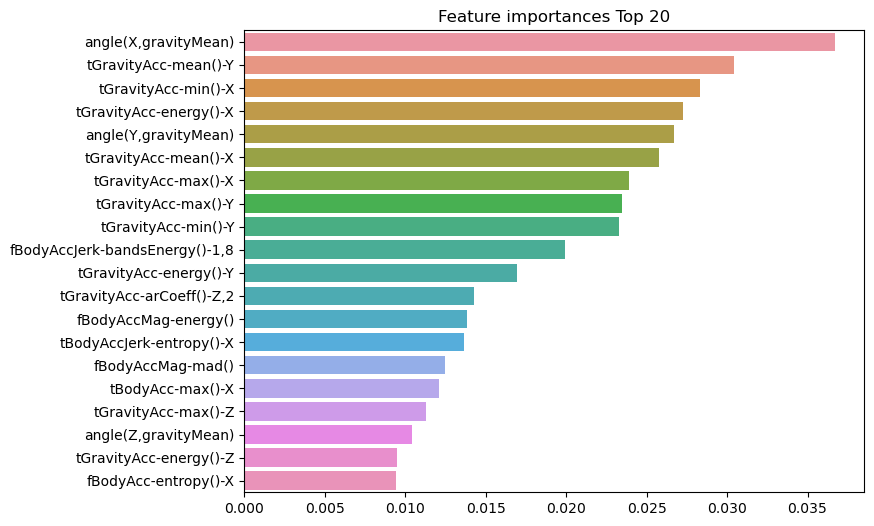

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## SVM

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

clf_svm = SVC(random_state=0)
clf_svm.fit(X_train, y_train)

pred_svm = clf_svm.predict(X_test)

print("\n--- SVM Classifier ---")
print(accuracy_score(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))


--- SVM Classifier ---
0.9504580929759077
[[488   5   3   0   0   0]
 [ 20 451   0   0   0   0]
 [ 10  26 384   0   0   0]
 [  0   2   0 438  51   0]
 [  0   0   0  29 503   0]
 [  0   0   0   0   0 537]]


## RF

In [8]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred_rf = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred_rf)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))
print (confusion_matrix(y_test, pred_rf))

랜덤 포레스트 정확도: 0.9253
[[486   4   6   0   0   0]
 [ 38 426   7   0   0   0]
 [ 22  44 354   0   0   0]
 [  0   0   0 440  51   0]
 [  0   0   0  48 484   0]
 [  0   0   0   0   0 537]]


## LR

In [9]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)

pred_lr = clf_lr.predict(X_test)

print ("\n--- Logistic Regression Classifier ---")
print (accuracy_score(y_test, pred_lr))
print (confusion_matrix(y_test, pred_lr))


--- Logistic Regression Classifier ---
0.9582626399728538
[[493   1   2   0   0   0]
 [ 25 445   1   0   0   0]
 [  4  14 402   0   0   0]
 [  0   3   0 430  58   0]
 [  0   0   0  15 517   0]
 [  0   0   0   0   0 537]]


## DT

In [10]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)

pred_dt = clf_dt.predict(X_test)

print ("\n--- Decision Tree Classifier ---")
print (accuracy_score(y_test, pred_dt))
print (confusion_matrix(y_test, pred_dt))


--- Decision Tree Classifier ---
0.8595181540549711
[[448  24  24   0   0   0]
 [ 74 367  30   0   0   0]
 [ 23  46 351   0   0   0]
 [  0   0   0 373 118   0]
 [  0   0   0  75 457   0]
 [  0   0   0   0   0 537]]


## 그리드서치